## Import Necessary Packages

In [11]:
import glob
import numpy as np
import xarray as xr
from scipy import interpolate
import proplot as pplt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [12]:
path = '/ocean/projects/atm200007p/sferrett/'
e3sm = np.squeeze(xr.open_mfdataset(path+'e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc')).drop_dims('nbnd').drop(('time','area'))
trmm_months  = xr.open_mfdataset(np.sort(glob.glob(path+'trmm/*_0[6-8]_*climo.nc')))
trmm_season  = xr.open_mfdataset(np.sort(glob.glob(path+'trmm/*_JJA_*climo.nc')))
imerg_months = xr.open_mfdataset(np.sort(glob.glob(path+'imerg/*_0[6-8]_*climo.nc*')))
imerg_season = xr.open_mfdataset(np.sort(glob.glob(path+'imerg/*_JJA_*climo.nc*')))
era5_months  = xr.open_mfdataset(np.sort(glob.glob(path+'era5/*_0[6-8]_*climo.nc')))
era5_season  = xr.open_mfdataset(np.sort(glob.glob(path+'era5/*_JJA_*climo.nc')))

## Standardize Data and Define Variables

In [13]:
time   = np.asarray(['JUN','JUL','AUG','JJA'])
trmm   = xr.concat((trmm_months,trmm_season),dim='time').drop_dims('bnds').assign_coords(date=('time',time)) 
imerg  = xr.concat((imerg_months,imerg_season),dim='time').transpose('time','lat','lon').assign_coords(date=('time',time))
era5   = xr.concat((era5_months,era5_season),dim='time').drop_dims('bnds').drop('height').assign_coords(date=('time',time))
names  = ['TRMM (1998 - 2013)','IMERG (2000 - 2020)','ERA5 (1979 - 2019)']
months = ['JUN','JUL','AUG','JJA']

## Plot the Spatial Distribution of Precipitation

In [4]:
lat1=5; lat2=25; lon1=65; lon2=90
trmmpr  = trmm.pr.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))*86400
imergpr = imerg.precipitation.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))*24
era5pr  = era5.pr.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))*86400

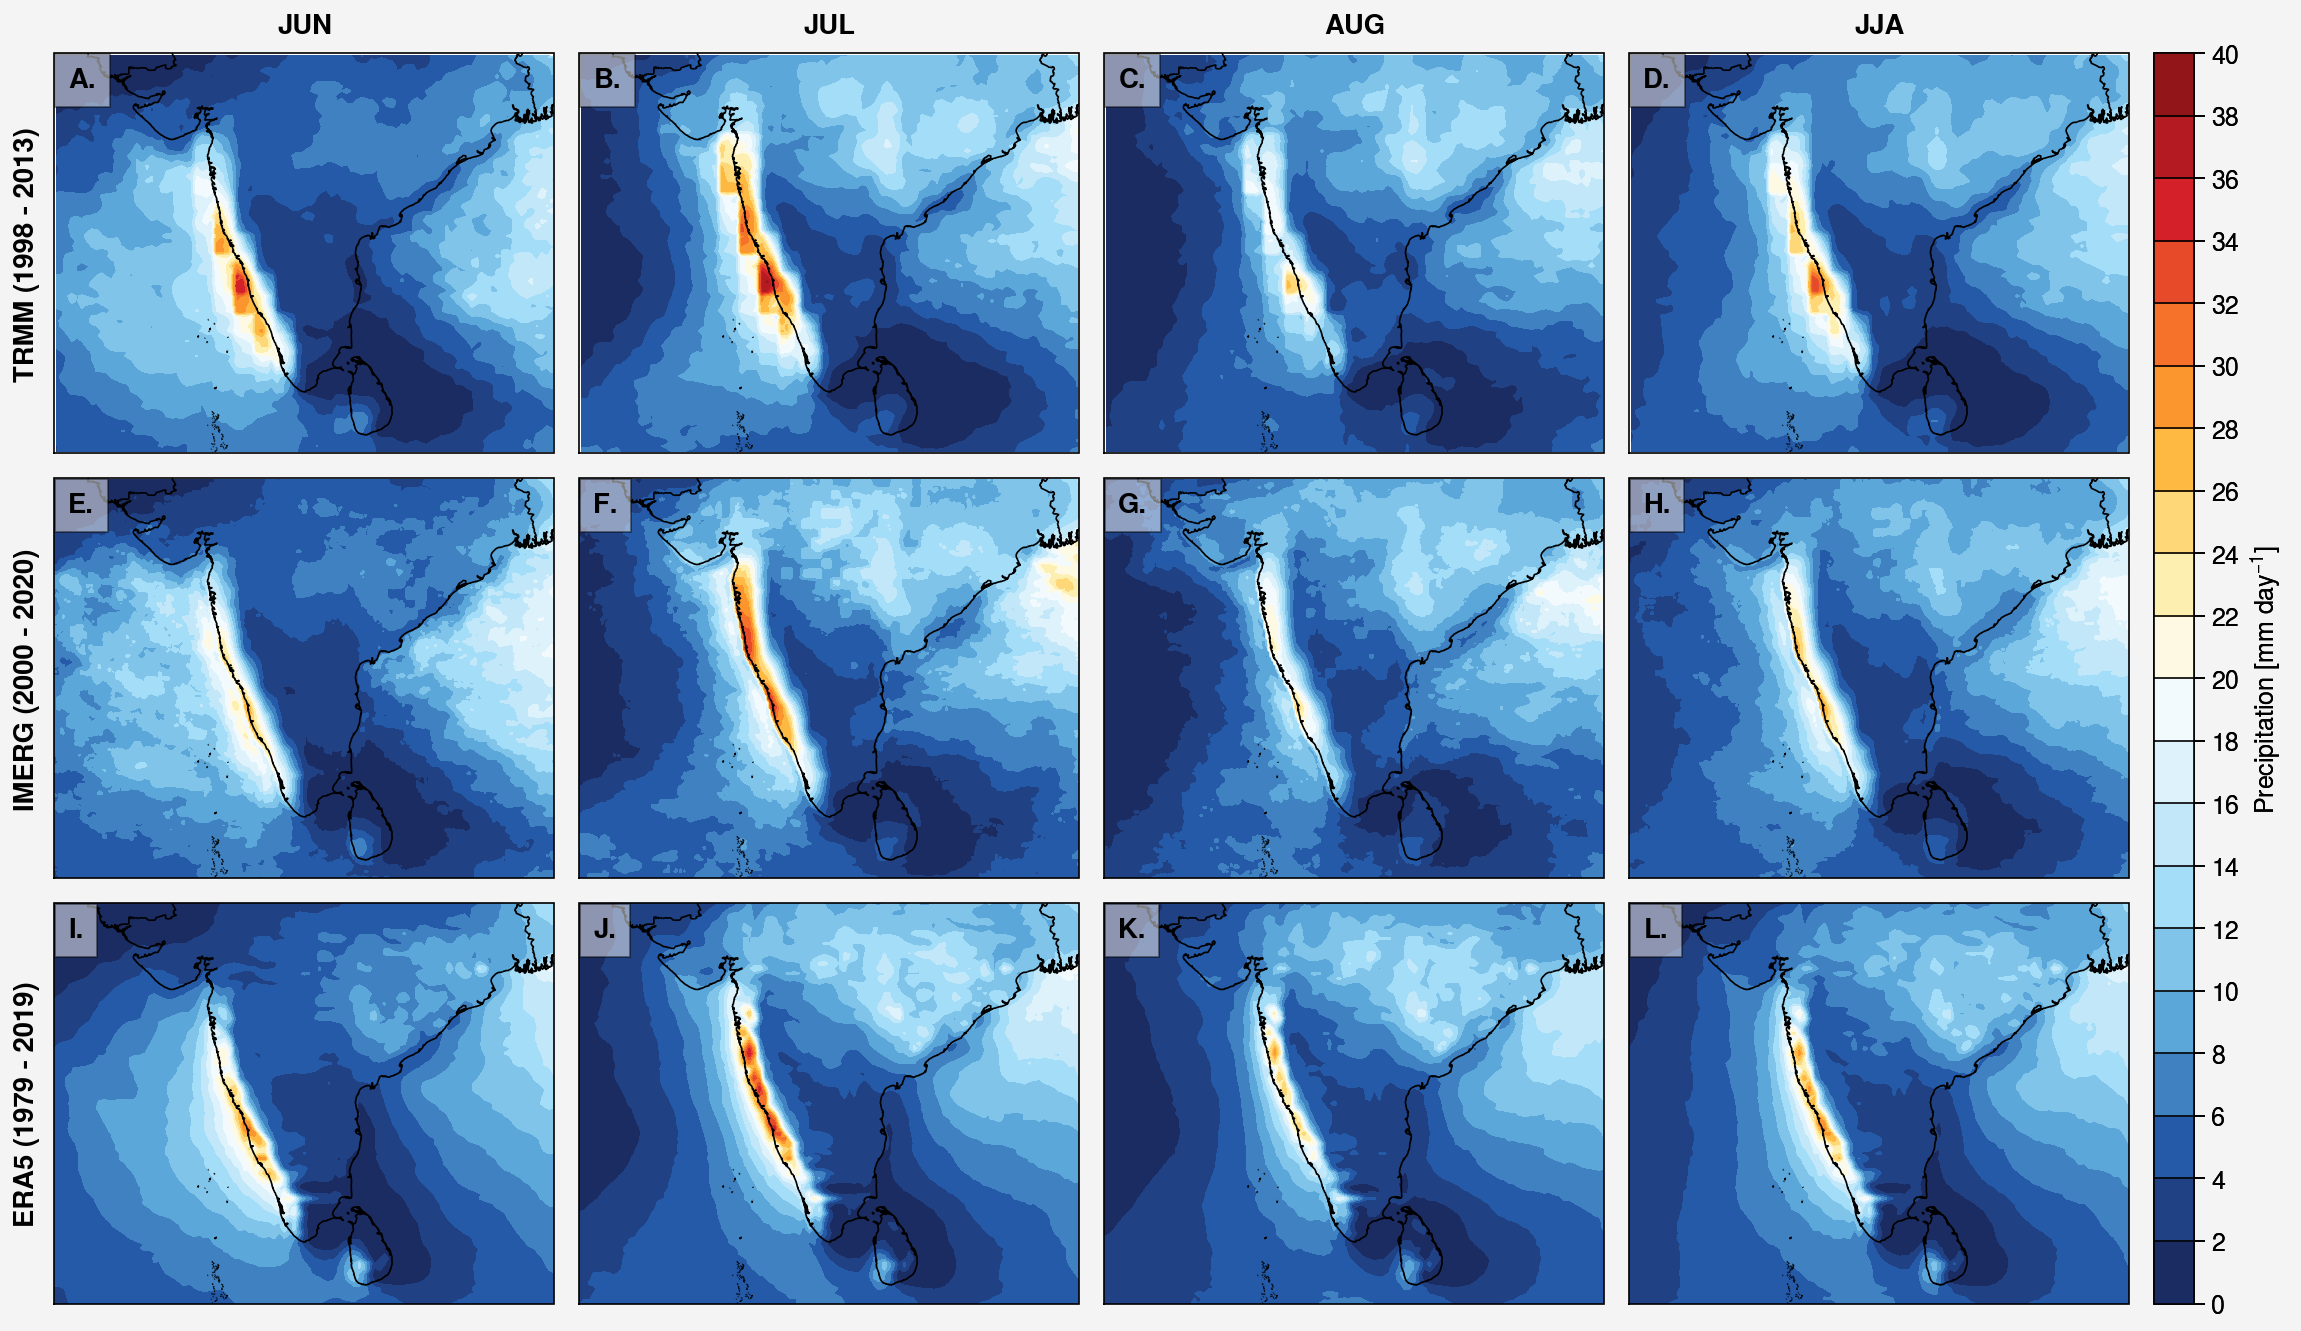

In [5]:
pplt.rc.reso='hi'; cmap='ColdHot'; levels=20; vmin=0; vmax=40
fig,axs = pplt.subplots(ncols=4,nrows=3,proj='cyl')
axs.format(grid=False,lonlim=(lon1,lon2),latlim=(lat1,lat2),land=False,coast=True,borders=True,borderscolor='black',
           abc='A.',abcloc='ul',abcbbox=True,rowlabels=names,collabels=months)
for i,months in enumerate(months): 
    maps = axs[i].contourf(trmmpr[i],cmap=cmap,levels=levels,vmin=vmin,vmax=vmax)   
    axs[i+4].contourf(imergpr[i],cmap=cmap,levels=levels,vmin=vmin,vmax=vmax)
    axs[i+8].contourf(era5pr[i],cmap=cmap,levels=levels,vmin=vmin,vmax=vmax)
fig.colorbar(maps,loc='r',grid=True,ticks=2,label='Precipitation [mm day$^{-1}$]')

## Plot Change in Monthly Precipitation Area

In [9]:
lat1=5; lat2=25; lon1=65; lon2=90
trmmpr  = trmm.pr.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))*86400
imergpr = imerg.precipitation.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))*24
era5pr  = era5.pr.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))*86400

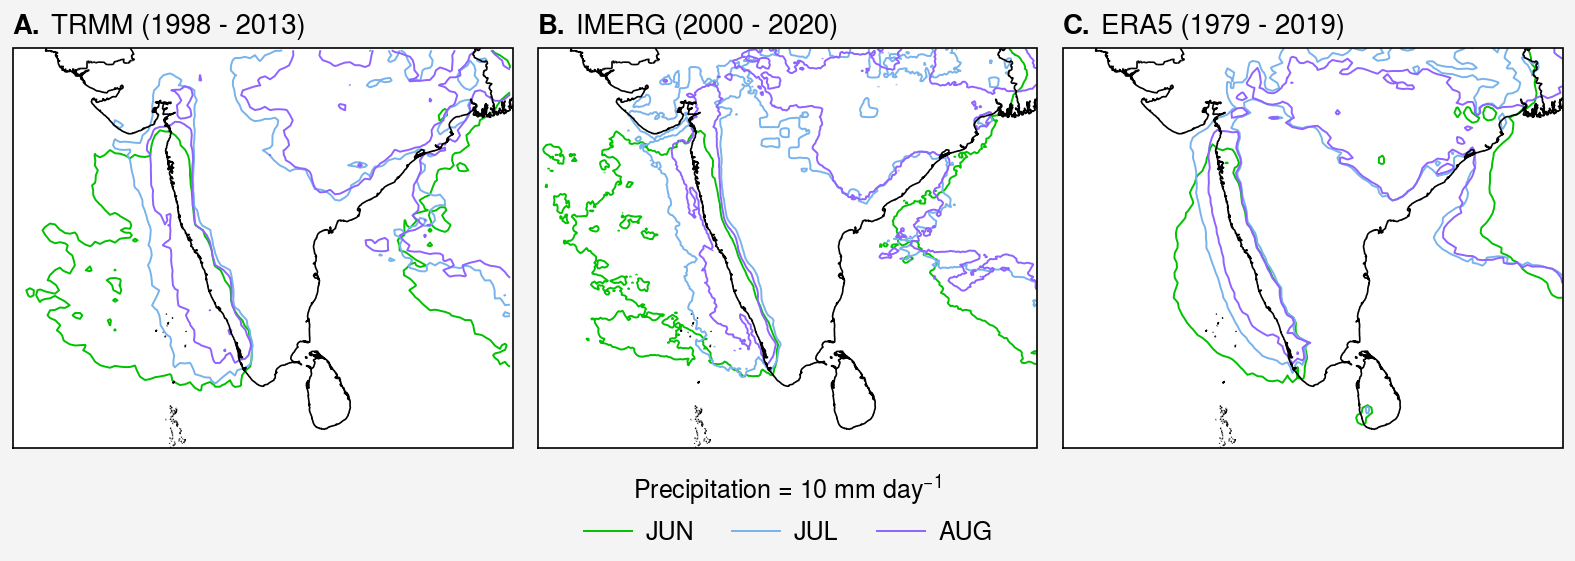

In [10]:
pplt.rc.reso='hi'; level=10; cmap=['green','steelblue','indigo']; linewidth=0.7; key=[]
fig,axs = pplt.subplots(ncols=3,nrows=1,proj='cyl')
for i,months in enumerate(months[:-1]):
    maps = axs[0].contour(trmmpr[i],cmap=cmap[i],levels=[level],linewidth=linewidth,months=[i])
    axs[1].contour(imergpr[i],cmap=cmap[i],levels=[level],linewidth=linewidth)
    axs[2].contour(era5pr[i],cmap=cmap[i],levels=[level],linewidth=linewidth)
    key.append(maps)
for j,ax in enumerate(axs):
    axs[j].format(grid=False,lonlim=(lon1,lon2),latlim=(lat1,lat2),land=False,coast=True,borders=True,
                  borderscolor='black',abc='A.',abcloc='l',titleloc='l',title=names[j])
C1=key[0].legend_elements()[0][0]; C2=key[1].legend_elements()[0][0]; C3=key[2].legend_elements()[0][0]
fig.legend([C1,C2,C3],['JUN','JUL','AUG'],loc='b',frame=False,title='Precipitation = '+str(level)+' mm day$^{-1}$')

## Plot Cross-Slope Profile of Precipitation

In [14]:
lat1=10; lat2=20; lon1=60; lon2=90
z = e3sm.PHIS.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')/9.80665/1000
e3smlon = e3sm.lon.sel(lon=slice(lon1,lon2))
trmmpr  = trmm.pr.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')*86400
imergpr = imerg.precipitation.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')*24
era5pr  = era5.pr.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')*86400

In [15]:
def transformlon(lon,data):
    transform = interpolate.interp1d((lon.sel(lon=slice(lon1,lon2))).to_numpy(),data.to_numpy(),bounds_error=False)
    return transform(e3smlon)
trmmpr  = transformlon(trmm.lon,trmmpr)
imergpr = transformlon(imerg.lon,imergpr)
era5pr  = transformlon(era5.lon,era5pr)

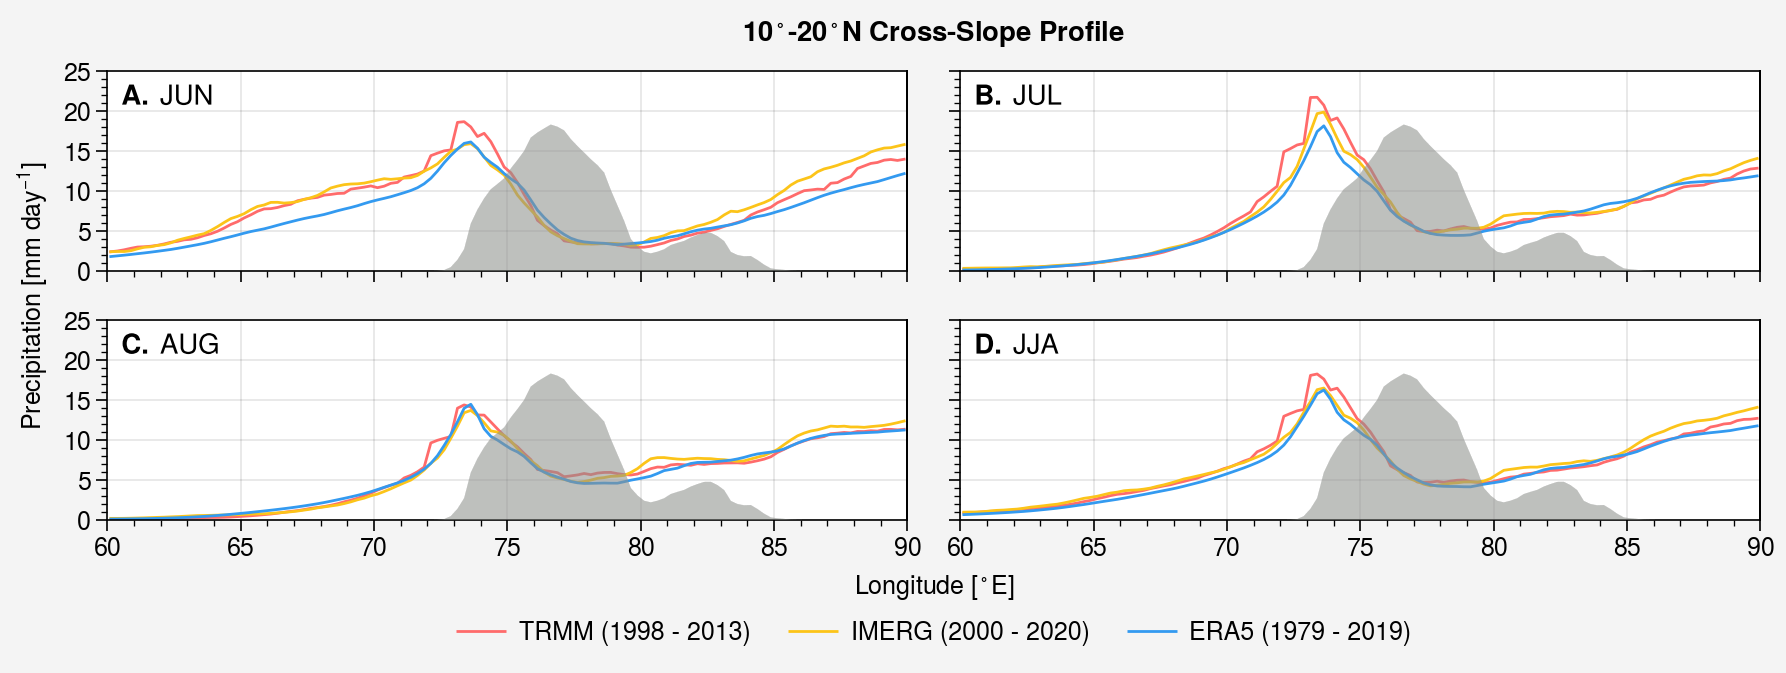

In [16]:
pplt.rc.reso='hi'; colors=np.asarray(['red5','yellow5','blue5']); linewidth=1
fig,axs = pplt.subplots(ncols=2,nrows=2,refwidth=4,refheight=1)
axs.format(suptitle=str(lat1)+'$^\circ$-'+str(lat2)+'$^\circ$N Cross-Slope Profile',abc='A.',abcloc='ul',
           xlabel='Longitude [$^\circ$E]',xlim=(lon1,lon2),xticks=5,
           ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,25),yticks=5)
for i,month in enumerate(months):
    trmmprof  = axs[i].plot(e3smlon,trmmpr[i],color=colors[0],linewidth=linewidth,label=names[0])
    imergprof = axs[i].plot(e3smlon,imergpr[i],color=colors[1],linewidth=linewidth,label=names[1])
    era5prof  = axs[i].plot(e3smlon,era5pr[i],color=colors[2],linewidth=linewidth,label=names[2])
    axs[i].format(titleloc='ul',title=months[i])
    oxs = axs.twinx()
    oxs.fill_between(e3smlon,z,fc='grey',alpha=0.1,zorder=0)
    oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
fig.legend((trmmprof,imergprof,era5prof),loc='b',ncols=3,frame=False)